In [1]:
import pandas as pd
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold


In [ ]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)

#Dtest
#Dapp
#On utilisera une méthode d'imputation qui gère différentes types pour les variables ! (cf Référence)
#On se doit tout de même spécifier le type des variables


In [2]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [ ]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))

In [ ]:
def g(l):
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [ ]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires


In [ ]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 


In [ ]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur cette variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [ ]:
##La variable ID hôpital sera supprimée, qui peut être considéré (globalement) comme un identifiant pour les chevaux
##en effet, si l'on conserve cette variable en termes d'ajustement, on sera performant.
##cependant, nos algorithmes de prédiction ne seront pas bons d'un point de vue de la généralisation
#62 lignes des données de test sont des nouveaux identifiants -- > overfitting

#Réf : Unleash Machine Learning Techniques, De Raghav Bali, Dipanjan Sarkar, Brett Lantz p.393
#Advances in Computing and Information Technolog, Natarajan Meghanathan, Dhinaharan Nagamalai, Nabendu Chaki P.352

In [ ]:
Dtest_imputed

In [ ]:
Dapp_cat

In [ ]:
Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

imputer = MissForest(random_state = 100)
Dtest_cat_imputed = imputer.fit_transform(Dtest_cat , cat_vars = cat_cols)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

In [ ]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque varible

In [ ]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

In [ ]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [ ]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

In [ ]:
Dapp_imputed

In [ ]:
Dtest_imputed.to_pickle("Dtest_imputed.pkl")
Dapp_imputed.to_pickle("Dapp_imputed.pkl")

In [3]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")

In [4]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V0" , "V2"] )]

In [5]:
##Régression logistique
scaler = StandardScaler()
Dapp_imputed[liste_numerical] = scaler.fit_transform(Dapp_imputed[liste_numerical])
Dapp_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed["V0"]])
Dapp_imputed = Dapp_imputed.astype({"V0" : "int32"})
Dapp_imputed = pd.get_dummies(Dapp_imputed , columns = liste_cat_bis , drop_first = True)

Dtest_imputed[liste_numerical] = scaler.transform(Dtest_imputed[liste_numerical])
Dtest_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed["V0"]])
Dtest_imputed = Dtest_imputed.astype({"V0" : "int32"})
Dtest_imputed = pd.get_dummies(Dtest_imputed , columns = liste_cat_bis , drop_first = True)

Dapp_imputed
Dtest_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_9,V6_2,...,V14_3,V16_2,V16_3,V16_4,V17_2,V17_3,V17_4,V17_5,V20_2,V20_3
0,0,0.500536,-0.647548,-0.651004,0.678060,-0.431817,-0.695687,-0.777540,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0,-0.867880,-0.862987,0.338104,-0.323003,-0.230760,-0.695687,1.401894,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,-0.715834,-1.006613,-0.156450,-0.348937,-0.130231,1.761921,-0.687021,0,0,...,0,0,1,0,0,0,0,1,0,1
3,1,-1.780158,-0.575735,-0.403727,-0.037726,-1.135516,1.414692,-0.687021,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,-0.563788,-1.078426,0.585381,0.169749,-1.034987,-0.699545,-0.596501,0,0,...,0,0,1,0,0,1,0,0,0,0
65,1,-0.259695,-0.432109,-1.145558,0.133441,-0.230760,1.569016,-0.687021,0,0,...,0,0,0,0,0,0,1,0,0,1
66,0,-0.259695,-1.078426,-1.145558,0.392783,-0.934459,-0.714978,-0.366721,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,-0.867880,0.573272,0.338104,-1.604156,-0.230760,-0.707261,6.603291,0,0,...,1,0,0,1,0,0,1,0,1,0


In [6]:
X_train = Dapp_imputed.drop(["V0"] , axis = 1) ; Y_train = Dapp_imputed["V0"]
X_test = Dtest_imputed.drop(["V0"] , axis = 1) ; Y_test = Dtest_imputed["V0"]

In [ ]:
##2 approches seront utilisées pour choisir les paramètres : - LOOCV
## en théorie, on pourrait considérer que nous avons un petit échantillon : on devrait effectuer des validations LOO
#pour déterminer les paramètres de nos méthodes
#on essaiera aussi des choix arbitraires de paramètres sur les données de test

In [16]:
def param_selection_log(X, y,Cs):
    logreg = LogisticRegression(penalty = "l2" , solver = "lbfgs" , max_iter = 500 , tol = 1e-6)
    parameters = {'C':Cs}
    clf = GridSearchCV(logreg, parameters , return_train_score = True , cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_

np.linalg.det(np.dot(np.transpose(X_train) , X_train)) #la matrice de design est bien de rang plein
#cependant, on ne pourra pas vérifier la séparabilité linéaire des données selon le label
#cela nous aurait garanti la convergence vers un minimum global

5.1017722290258385e+66

In [17]:
logreg = LogisticRegression(penalty = "none",solver = "lbfgs" , max_iter = 500 , tol = 1e-6)
#pas de multicolinéairité, on pourrait aussi simplement dire que nous ne sommes pas en grande dimension
#donc pas de pénalité
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)

0.7058823529411765

Text(0, 0.5, 'Second Principal Component')

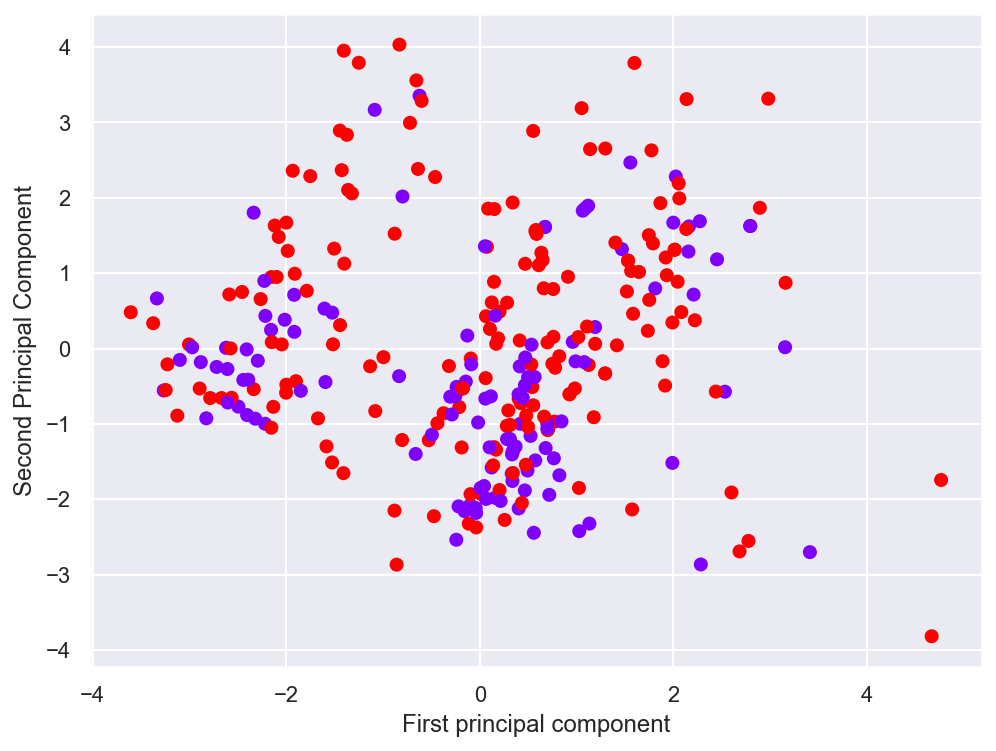

In [18]:
#Faisons une ACP pour avoir une intuition sur la séparabilité linéaire des données
pca = decomposition.PCA(n_components=3)
pca.fit(X_train)
X = pca.transform(X_train)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0] , X[:,1] ,c=Y_train,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

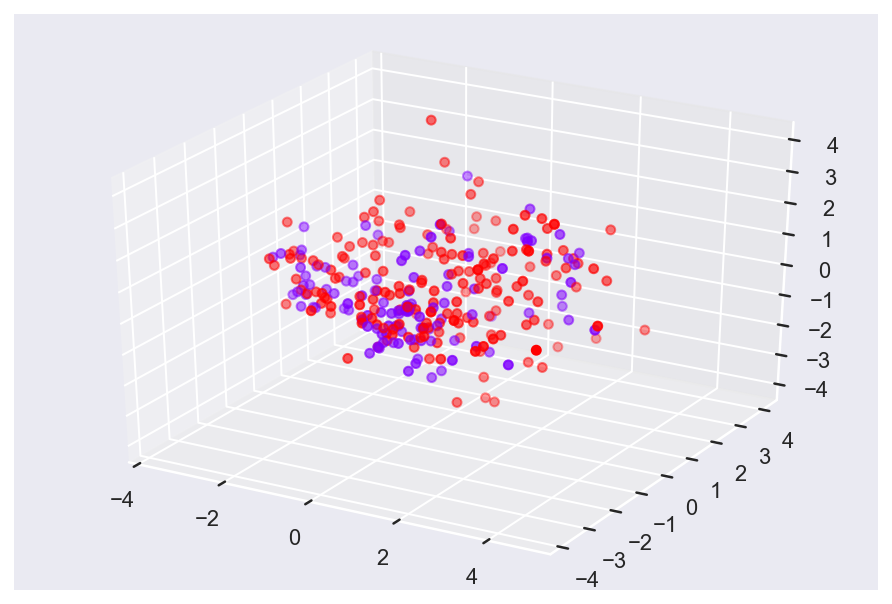

In [19]:
#3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=Y_train , cmap = "rainbow")
## ce ne sont que des outils de visualisation et au vue de notre score sur les Dapp, on pourrait penser que les donnéees
#ne sont pas linéairement séparables (on utilise un classifieur linéaire) -- > information très importante
## il y a de fortes chances que l'algorithme itératif de la régression logistique n'ait atteint qu'un minimum
#local

In [39]:
def svc_param_selection_lin(X, y,Cs):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['linear'], 'C':Cs}
    svc = svm.SVC(gamma = 1 , coef0 = 0)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_

C = svc_param_selection_lin(X_train, Y_train , np.linspace(0.01,11,4))["C"]
#Naturellement, on se dirigera vers les SVM non linéaires de manière à déterminer un hyperplan dans un espace 
#de plus grande dimension

clf = LinearSVC(C = C , max_iter = 10000)
clf.fit(X_train , Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)



clf = LinearSVC(C = 0.01 , max_iter = 1000)
clf.fit(X_train , Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#même performance que la régression logistique, avec un paramètre C trouvé de manière exploratoire



#accuracy_score(y_fit, Y_train)
#on constate donc que les performances sont similaires, on aura beau augmenté la constante de tolérance cela
#ne fera pas augmenter le taux de bon classés dans les données d'apprentissage au contraire ...
#on insiste bien sur l'erreur d'ajustement car c'est un moyen de juger la non-séparabilité 
#avec les données de départ, il semble difficile de déterminer un hyperplan comme en régression logistique
#on décide donc d'opter pour les SVM à noyaux

0.7205882352941176

In [42]:
clf = LinearSVC(C = C , max_iter = 10000)
clf.fit(X_train , Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
accuracy_score(y_pred, Y_test)


0.6911764705882353

In [43]:
def svc_param_selection_poly(X, y,Cs , degree):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['poly'], 'C':Cs , "degree" : degree}
    svc = svm.SVC(gamma = "auto")
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_
params_poly = svc_param_selection_poly(X_train, Y_train , np.linspace(0.01,11,4) , list(range(1,4)))
ksvm_poly = svm.SVC(kernel="poly", degree = params_poly["degree"] , C = params_poly["C"] , gamma = "auto")               
ksvm_poly.fit(X_train, Y_train)
y_pred = ksvm_poly.predict(X_test)
y_fit = ksvm_poly.predict(X_train)
accuracy_score(y_pred, Y_test)
accuracy_score(y_fit, Y_train)
## sur la base de nos grilles choisies, le meilleur score obtenu provient d'une SVM linéaire classique
## on décide de ne pas optimiser la constante du polynôme
## les résultats sont différents de la SVM utilisée au préalable (peut-être à cause d'une implémentation différente)

0.75

In [54]:
def svc_param_selection(X, y,Cs,Gs): #on se limite à une VC 5-fold car moins coûteuse
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'C': Cs, 'gamma': Gs, 'kernel': ['rbf']}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 5))
    clf.fit(X_train, Y_train)
    return clf.best_params_

params = svc_param_selection(X_train, Y_train , np.linspace(0.01,11,4) , [1, 0.1, 0.01, 0.001, 0.0001])

ksvm = svm.SVC(kernel="rbf", gamma = params["gamma"] , C = params["C"])               
ksvm.fit(X_train, Y_train)
y_pred = ksvm.predict(X_test)
y_fit = ksvm.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)
#le choix de gamma peut s'avérer très compliqué, il en est de même pour le choix du noyau ainsi que de la tolérance,
#on se limite donc à chercher une constante de tolérance optimal pour un noyau RBF
#on pourrait vérifier que si C est grand alors le taux de classification est égal à 1
#on voit aussi que les performances sur les données de test sont moins bonnes

0.6029411764705882

In [55]:
def oob_m(liste): #renvoie le m minimisant l'erreur OOB
    l = []
    for m in liste:
        clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
        clf.fit(X_train, Y_train)
        l.append((m , clf.oob_score_))
    return min(l , key = lambda x : x[1])[0]

m = oob_m(range(1,8))

In [58]:
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)

#dans notre cas de figure, déterminer m à l'aide de l'erreur OOB peut être une source de sur-apprentissage
#on optera pour une validation croisée pour déterminer m

0.7058823529411765

In [127]:
def rfc_CV(ms):
    rfc = RandomForestClassifier(random_state = 0, min_samples_split = 2,
                            oob_score = True , n_estimators = 100)
    param_grid = {'max_features': ms}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_rfc.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"]
#on décide de faire une 5-fold car la LOO est coûteuse

In [128]:
ms = list(range(1,6))
m = rfc_CV(ms)
rfc = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
y_fit = rfc.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)



#le meilleur modèle jusqu'à présent sur les données de test
#on constatera que même avec m = 44, l'erreur d'ajustement est nulle

0.7058823529411765

In [62]:
def knn_CV(ks):
    neigh = KNeighborsClassifier()
    param_grid = {'n_neighbors': ks}
    CV_knn = GridSearchCV(estimator=neigh, param_grid=param_grid, cv= KFold(n_splits = 300))
    CV_knn.fit(X_train, Y_train)
    return CV_knn.best_params_["n_neighbors"]
k = knn_CV(list(range(2,10)))

In [145]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit , Y_train)

0.6176470588235294

In [137]:
def ada_CV(ns):
    ada = AdaBoostClassifier(random_state=0)
    param_grid = {'n_estimators': ns}
    CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_ada.fit(X_train, Y_train)
    return CV_ada.best_params_["n_estimators"]
B = ada_CV(list(range(40,50)))

In [138]:
clf = AdaBoostClassifier(n_estimators = B, random_state=0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)


0.6911764705882353

In [126]:
(accuracy_score(y_fit, Y_train))

0.85